In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from pprint import pprint
%matplotlib inline
import seaborn as sns

import googlemaps

## Imput API Key to Google Maps
You will need to create a GoogleMapsPlatform account and request the tokens for API. You have $200 of credit per month before you are charged. <br>
https://cloud.google.com/maps-platform/?_ga=2.236356802.2140659423.1614442015-1614339458.1614213866

In [2]:
api_key = open('C:/Users/Callie/Documents/PythonText/google_api_key.txt','r')
gmaps = googlemaps.Client(key=api_key.readline())
api_key.close()

## Read in CSV
I could not find a reliable API to pull all of the rentals in the area, so I ended up manual entering the data for each apartment. While the listings will not stay up to date. It will give me a general idea for pricing at each location.

In [3]:
df = pd.read_csv('personal_apartment_list.csv')
df = df.ffill()

zipcode = []

for i, z in df.iterrows():
    zipcode.append(z.address.split(' ')[-1])

df['zipcode'] = zipcode
df = df.astype({'zipcode':'int64'})


df['priceSquareFoot'] = df.price / df.squareFootage

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   address          42 non-null     object 
 1   bedrooms         42 non-null     int64  
 2   bathrooms        42 non-null     float64
 3   price            42 non-null     int64  
 4   squareFootage    42 non-null     int64  
 5   floorplan        42 non-null     object 
 6   complex          42 non-null     object 
 7   covered_parking  42 non-null     float64
 8   balcony          42 non-null     int64  
 9   washer_dryer     42 non-null     int64  
 10  loft             42 non-null     int64  
 11  hardwood_floors  42 non-null     int64  
 12  office           42 non-null     int64  
 13  open_concept     42 non-null     int64  
 14  high_ceiling     42 non-null     int64  
 15  pets             42 non-null     int64  
 16  zipcode          42 non-null     int64  
 17  priceSquareFoot  4

In [4]:
df.zipcode.unique()

array([22041, 22302, 22150, 22303, 22304, 22310, 22312, 22314, 22206],
      dtype=int64)

In [5]:
crime = pd.read_csv('data/CrimeZipcode.csv')
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   ZipCode         10 non-null     int64
 1   Assualt         10 non-null     int64
 2   Burglary        10 non-null     int64
 3   Larceny         10 non-null     int64
 4   Murder          10 non-null     int64
 5   Vehicle_Theft   10 non-null     int64
 6   PersonalCrime   10 non-null     int64
 7   PropertryCrime  10 non-null     int64
 8   Rape            10 non-null     int64
 9   Robbery         10 non-null     int64
 10  TotalCrime      10 non-null     int64
dtypes: int64(11)
memory usage: 1008.0 bytes


In [72]:
def score_crime(row):
    score=((row.Assualt +
            row.Burglary +
            row.Vehicle_Theft +
            row.PropertryCrime +
            row.Robbery +
            row.Rape*2
            )/row.TotalCrime)
    return score

In [73]:
%%time
crime_score = []

for i, x in df.iterrows():
    temp = None
    for j, row in crime.iterrows():
        if x.zipcode == row.ZipCode:
            temp = score_crime(row)
    if temp == None:
        print(x.zipcode)
    crime_score.append(temp)
            
df['crime'] = crime_score

Wall time: 29.9 ms


In [8]:
complex_address = df.address.unique()

len(complex_address)

14

In [9]:
%%time
latitude = {}
longitude = {}

for address in complex_address:
    geocode_result = gmaps.geocode(address)
    geocode = geocode_result[0]['geometry']['location']
    latitude[address] = geocode['lat']
    longitude[address] = geocode['lng']
    
Lat = []
Long = []
for i, row in df.iterrows():
    Lat.append(latitude[row.address])
    Long.append(longitude[row.address])
    
df['latitude'] = Lat
df['longitude'] = Long

df.head()

Wall time: 5.66 s


,address,bedrooms,bathrooms,price,squareFootage,floorplan,complex,covered_parking,balcony,washer_dryer,...,hardwood_floors,office,open_concept,high_ceiling,pets,zipcode,priceSquareFoot,crime,latitude,longitude
0,"5600 Columbia Pike, Falls Church, VA 22041",1,1.0,1837,962,Inspire,Mission Lofts,1.0,0,1,...,1,0,1,1,1,22041,1.909563,152,38.853992,-77.123056
1,"5600 Columbia Pike, Falls Church, VA 22041",2,1.0,2378,1083,Objective,Mission Lofts,1.0,0,1,...,1,0,1,1,1,22041,2.195753,152,38.853992,-77.123056
2,"5600 Columbia Pike, Falls Church, VA 22041",2,2.5,2387,1092,Purpose,Mission Lofts,1.0,0,1,...,1,0,1,1,1,22041,2.185897,152,38.853992,-77.123056
3,"5600 Columbia Pike, Falls Church, VA 22041",1,1.0,1803,720,Aspire,Mission Lofts,1.0,1,1,...,1,0,1,1,1,22041,2.504167,152,38.853992,-77.123056
4,"4501 Ford Ave, Alexandria, VA 22302",1,1.0,1724,632,6C,E-Lofts,1.0,0,1,...,1,0,1,1,1,22302,2.727848,486,38.837194,-77.105277


In [82]:
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
gis = GIS()

sdf = pd.DataFrame.spatial.from_xy(df, 'longitude','latitude')

pdx_map = gis.map('Lincolnia, VA', zoomlevel=10)
pdx_map.basemap = 'gray-vector'
pdx_map

MapView(layout=Layout(height='400px', width='100%'))

In [83]:
sdf.spatial.plot(map_widget=pdx_map,
                 renderer_type='c',
                 method = 'esriClassifyNaturalBreaks',
                 class_count = 5,
                 col = 'crime',
                 cmap = 'RdBu_r',
                 alpha = .7,
                 outline_color=[50,0,0,50], line_width=1)

True

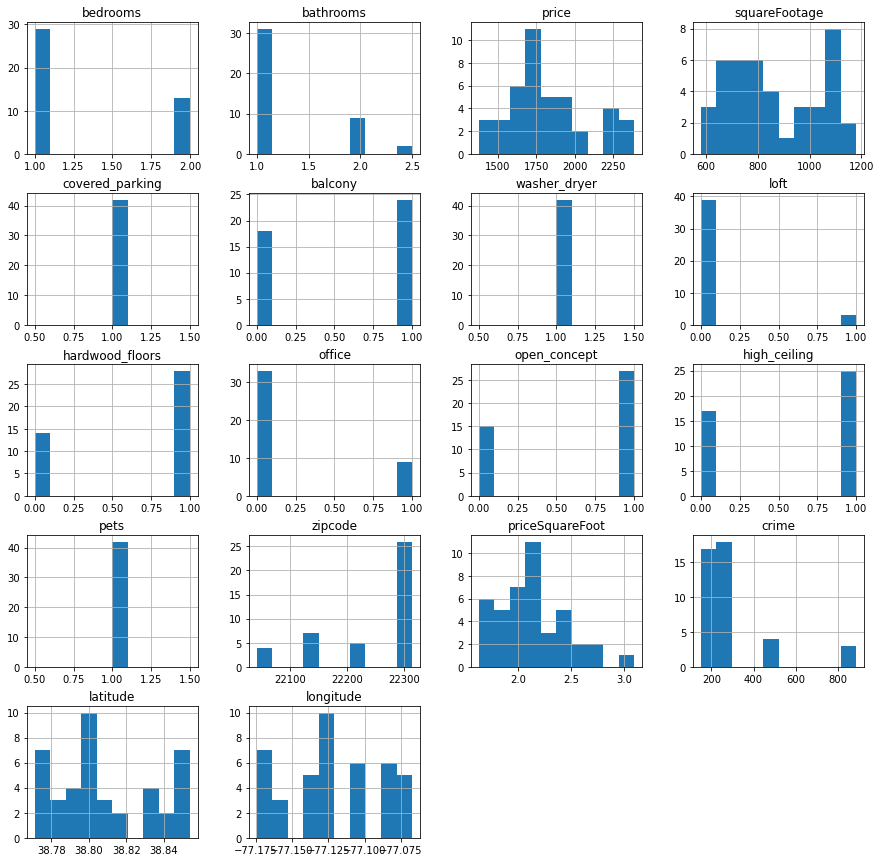

In [12]:
ax_list = df.hist(bins=10, figsize=(15,15))

## Calulate the Commute Time

In [13]:
# Input a date in the future and the time you would like to arrive at work

arrive =datetime(2021, 5, 18, 7, 30, 0)
print(arrive)

2021-05-18 07:30:00


In [14]:
%%time

commute = {}

office = open('C:/Users/Callie/Documents/PythonText/Office_Address.txt','r')
off_ad = office.readline()

for address in complex_address:
    Origin = address
    Destination = off_ad
    
    results = gmaps.distance_matrix(Origin,
                                    Destination, 
                                    mode='driving', 
                                    arrival_time=arrive)
    
    commute[address] = results['rows'][0]['elements'][0]['duration']['text']
    
office.close()
commute

Wall time: 5.6 s


{'5600 Columbia Pike, Falls Church, VA 22041': '19 mins',
 '4501 Ford Ave, Alexandria, VA 22302': '16 mins',
 '6802 Junction Blvd, Springfield, VA 22150': '8 mins',
 '6200 N Kings Hwy, Alexandria, VA 22303': '21 mins',
 '5000 Eisenhower Ave, Alexandria, VA 22304': '13 mins',
 '6001 Archstone Way, Alexandria, VA 22310': '15 mins',
 '5760 Dow Ave, Alexandria, VA 22304': '16 mins',
 '5575 Vincent Gate Terrace, Alexandria, VA 22312': '12 mins',
 '2201 Mill Rd, Alexandria, VA 22314': '17 mins',
 '2727 S Quincy St, Arlington, VA 22206': '15 mins',
 '1800 26th St S, Arlington, VA 22206': '17 mins',
 '5250 Duke St, Alexandria, VA 22304': '14 mins',
 '766 N Howard St, Alexandria, VA 22304': '17 mins',
 '2700 Williamsburg St, Alexandria, VA 22314': '16 mins'}

In [15]:
commute_time = []

for i, row in df.iterrows():
    commute_time.append(commute[row.address].split(' ')[0])
    
df['commute_time'] = commute_time

df = df.astype({'commute_time':'int64'})

## Count the Number of Entities with 2km of the Complex
We are specifically looking for the number of:
<ul>
    <li>Grocery Stores</li>
    <li>Bars</li>
    <li>Gas Stations</li>
    <li>Restaurants</li>
    <li>Hospitals </li>
    <li>Parks</li>
</ul>
Google was returning Entities outside of my specified radius so I am using the Haversine Distance to check it is less than 2km

In [16]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
    return np.round(res, 2)

In [17]:
%%time

grocery = {}
bars = {}
gas = {}
resturants = {}
hospitals = {}
parks = {}

for address in complex_address:
    location = (latitude[address],longitude[address])
    gr = gmaps.places(query='grocery store', location=location, radius=500, type='supermarket')
    ba = gmaps.places(query='bar', location=location, radius=500)
    ga = gmaps.places(query='gas station', location=location, radius=500)
    re = gmaps.places(query='resturant', location=location, radius=500)
    ho = gmaps.places(query='hospitals', location=location, radius=500)
    pa = gmaps.places(query='parks', location=location, radius=500)
    
    gr_count = 0
    for x in gr['results']:
        gr_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], gr_location['lat'],gr_location['lng']) < 2:
            gr_count +=1
            
    ba_count = 0
    for x in ba['results']:
        ba_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], ba_location['lat'],ba_location['lng']) < 2:
            ba_count +=1
    
    ga_count = 0
    for x in ga['results']:
        ga_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], ga_location['lat'],ga_location['lng']) < 2:
            ga_count +=1
            
    re_count = 0
    for x in re['results']:
        re_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], re_location['lat'],re_location['lng']) < 2:
            re_count +=1
            
    ho_count = 0
    for x in ho['results']:
        ho_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], ho_location['lat'],ho_location['lng']) < 2:
            ho_count +=1
            
    pa_count = 0
    for x in pa['results']:
        pa_location = x['geometry']['location']
        if haversine_distance(latitude[address],longitude[address], pa_location['lat'],pa_location['lng']) < 2:
            pa_count +=1
            
    
    grocery[address] = gr_count
    bars[address] = ba_count
    gas[address] = ga_count
    resturants[address] = re_count
    hospitals[address] = ho_count
    parks[address] = pa_count

Wall time: 1min 19s


In [18]:
grocery_count = []
bar_count = []
gas_count = []
resturant_count = []
hospital_count = []
park_count = []

for i, row in df.iterrows():
    grocery_count.append(grocery[row.address])
    bar_count.append(bars[row.address])
    gas_count.append(gas[row.address])
    resturant_count.append(resturants[row.address])
    hospital_count.append(hospitals[row.address])
    park_count.append(parks[row.address])
    
df['grocery_count'] = grocery_count
df['bar_count'] = bar_count
df['gas_count'] = gas_count
df['resturant_count'] = resturant_count
df['hospital_count'] = hospital_count
df['park_count'] = park_count

In [19]:
df.describe().round(3)

,bedrooms,bathrooms,price,squareFootage,covered_parking,balcony,washer_dryer,loft,hardwood_floors,office,...,crime,latitude,longitude,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count
count,42.000,42.000,42.000,42.000,42.0,42.000,42.0,42.000,42.000,42.000,...,42.000,42.000,42.000,42.000,42.000,42.000,42.000,42.000,42.000,42.000
mean,1.310,1.286,1817.524,867.167,1.0,0.571,1.0,0.071,0.667,0.214,...,270.667,38.809,-77.122,14.667,5.500,7.405,9.095,12.024,0.500,10.119
std,0.468,0.496,262.964,176.964,0.0,0.501,0.0,0.261,0.477,0.415,...,196.753,0.028,0.035,3.791,2.277,4.061,3.850,3.979,0.741,5.023
min,1.000,1.000,1376.000,580.000,1.0,0.000,1.0,0.000,0.000,0.000,...,150.000,38.771,-77.174,8.000,0.000,0.000,4.000,3.000,0.000,3.000
25%,1.000,1.000,1646.750,709.500,1.0,0.000,1.0,0.000,0.000,0.000,...,152.750,38.794,-77.139,13.000,4.000,5.000,5.500,10.000,0.000,4.500
50%,1.000,1.000,1750.500,815.500,1.0,1.000,1.0,0.000,1.000,0.000,...,228.000,38.802,-77.123,15.000,5.000,9.000,8.000,12.000,0.000,12.500
75%,2.000,1.750,1930.500,1055.000,1.0,1.000,1.0,0.000,1.000,0.000,...,232.500,38.837,-77.091,17.000,7.000,9.000,12.750,14.000,1.000,14.000
max,2.000,2.500,2387.000,1180.000,1.0,1.000,1.0,1.000,1.000,1.000,...,887.000,38.854,-77.067,21.000,9.000,17.000,16.000,18.000,2.000,17.000


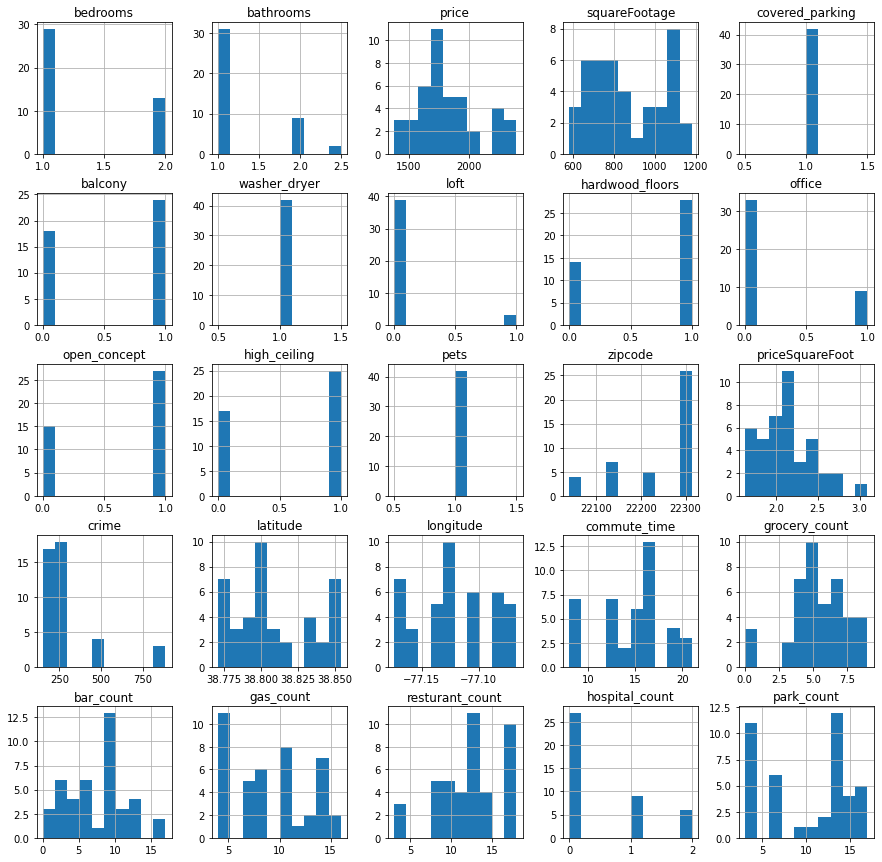

In [20]:
ax_list = df.hist(bins=10, figsize=(15,15))

## Score the Apartments
Now to create the decision Matrix. For each category I have choosen a weight on the importance. I plan to add commute times to other location that I frequent often (ex: Favorite Italian Resturant, Wegmens)


In [21]:
def set_score(row):
    score = (row['price']*-1.5 + 
             row['bedrooms']+ 
             row['bathrooms'] + 
             row['squareFootage']*1.5 + #I want a large apartment
             row['covered_parking']*2 + 
             row['commute_time']*-4 +  #I go to the office 4 days a week
             row['grocery_count'] +
             row['bar_count']*.5 +
             row['gas_count'] +
             row['resturant_count'] +
             row['hospital_count']*-1 + #Penalize for sound
             row['park_count']*2 +
             row['hardwood_floors']+
             row['open_concept'] +
             row['high_ceiling']*.5 +
             row['office']*2 +
             row['crime']*-1
            )
             
    return score

In [22]:
%%time
df['scores'] = df.apply(set_score, axis=1)

Wall time: 8.01 ms


In [23]:
df.describe().round(3)

,bedrooms,bathrooms,price,squareFootage,covered_parking,balcony,washer_dryer,loft,hardwood_floors,office,...,latitude,longitude,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count,scores
count,42.000,42.000,42.000,42.000,42.0,42.000,42.0,42.000,42.000,42.000,...,42.000,42.000,42.000,42.000,42.000,42.000,42.000,42.000,42.000,42.000
mean,1.310,1.286,1817.524,867.167,1.0,0.571,1.0,0.071,0.667,0.214,...,38.809,-77.122,14.667,5.500,7.405,9.095,12.024,0.500,10.119,-1698.179
std,0.468,0.496,262.964,176.964,0.0,0.501,0.0,0.261,0.477,0.415,...,0.028,0.035,3.791,2.277,4.061,3.850,3.979,0.741,5.023,376.693
min,1.000,1.000,1376.000,580.000,1.0,0.000,1.0,0.000,0.000,0.000,...,38.771,-77.174,8.000,0.000,0.000,4.000,3.000,0.000,3.000,-2784.500
25%,1.000,1.000,1646.750,709.500,1.0,0.000,1.0,0.000,0.000,0.000,...,38.794,-77.139,13.000,4.000,5.000,5.500,10.000,0.000,4.500,-2010.125
50%,1.000,1.000,1750.500,815.500,1.0,1.000,1.0,0.000,1.000,0.000,...,38.802,-77.123,15.000,5.000,9.000,8.000,12.000,0.000,12.500,-1578.750
75%,2.000,1.750,1930.500,1055.000,1.0,1.000,1.0,0.000,1.000,0.000,...,38.837,-77.091,17.000,7.000,9.000,12.750,14.000,1.000,14.000,-1407.750
max,2.000,2.500,2387.000,1180.000,1.0,1.000,1.0,1.000,1.000,1.000,...,38.854,-77.067,21.000,9.000,17.000,16.000,18.000,2.000,17.000,-1225.000


C:\Users\Callie\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='scores', ylabel='Density'>

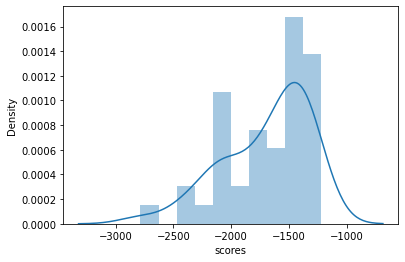

In [24]:
#Distribution of the Scores
sns.distplot(df['scores'], bins=10)

C:\Users\Callie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


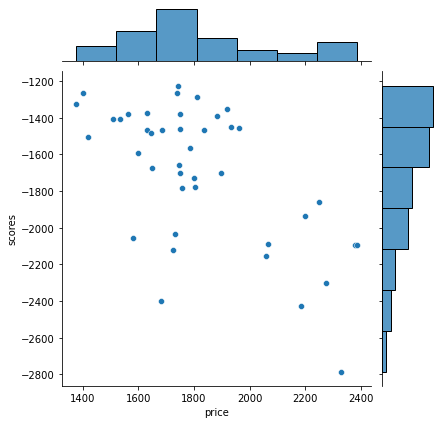

In [25]:
#Shows how the score correlates to the price
sns.jointplot('price','scores',data=df)

In [26]:
df.to_csv('data/apartment_scores_unscaled.csv')

## Scale the Data
The initial scoreing method is strongly influened by price so we scale it so it't between 0:1

In [27]:
from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler()

In [30]:
columns_to_scale = ['price', 'bedrooms','bathrooms','squareFootage','covered_parking',
                    'commute_time','grocery_count','bar_count','gas_count','resturant_count',
                    'hospital_count', 'park_count', 'hardwood_floors', 'office','open_concept',
                    'high_ceiling','crime']

scaled_array = mm_scaler.fit_transform(df[columns_to_scale])
df_scaled = pd.DataFrame(scaled_array, columns=columns_to_scale)

df_scaled.head()

,price,bedrooms,bathrooms,squareFootage,covered_parking,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count,hardwood_floors,office,open_concept,high_ceiling,crime
0,0.455984,0.0,0.0,0.636667,0.0,0.846154,1.000000,0.705882,0.833333,0.600000,0.0,0.785714,1.0,0.0,1.0,1.0,0.002714
1,0.991098,1.0,0.0,0.838333,0.0,0.846154,1.000000,0.705882,0.833333,0.600000,0.0,0.785714,1.0,0.0,1.0,1.0,0.002714
2,1.000000,1.0,1.0,0.853333,0.0,0.846154,1.000000,0.705882,0.833333,0.600000,0.0,0.785714,1.0,0.0,1.0,1.0,0.002714
3,0.422354,0.0,0.0,0.233333,0.0,0.846154,1.000000,0.705882,0.833333,0.600000,0.0,0.785714,1.0,0.0,1.0,1.0,0.002714
4,0.344214,0.0,0.0,0.086667,0.0,0.615385,0.888889,0.529412,0.583333,0.533333,1.0,0.714286,1.0,0.0,1.0,1.0,0.455902


C:\Users\Callie\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='scaled_score', ylabel='Density'>

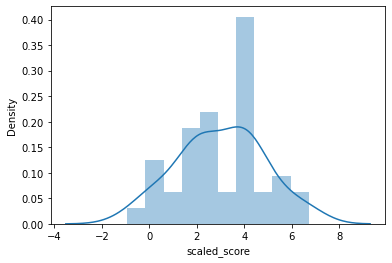

In [31]:
df_scaled['scaled_score'] = df_scaled.apply(set_score, axis=1)
sns.distplot(df_scaled['scaled_score'], bins=10)

In [33]:
df['scaled_scores'] = df_scaled['scaled_score']

C:\Users\Callie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


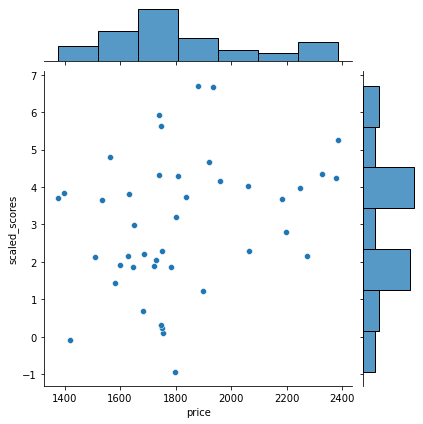

In [34]:
sns.jointplot('price','scaled_scores',data=df)

In [35]:
df_sorted = df.sort_values(by='scaled_scores', ascending= False)
df_sorted.reset_index(drop=True, inplace=True)
df_sorted['rank'] = df_sorted.index

df_sorted.head()

,address,bedrooms,bathrooms,price,squareFootage,floorplan,complex,covered_parking,balcony,washer_dryer,...,commute_time,grocery_count,bar_count,gas_count,resturant_count,hospital_count,park_count,scores,scaled_scores,rank
0,"5000 Eisenhower Ave, Alexandria, VA 22304",2,2.0,1882,1103,Blakely,The Reserve at Eisenhower Apartments,1.0,1,1,...,13,5,5,8,13,0,13,-1388.0,6.706244,0
1,"5000 Eisenhower Ave, Alexandria, VA 22304",2,2.0,1934,1115,Bingham,The Reserve at Eisenhower Apartments,1.0,1,1,...,13,5,5,8,13,0,13,-1448.0,6.659093,1
2,"5250 Duke St, Alexandria, VA 22304",2,2.0,1741,1067,Elm,The Arbors on Duke,1.0,1,1,...,14,6,6,13,14,1,15,-1225.0,5.927321,2
3,"1800 26th St S, Arlington, VA 22206",2,2.0,1748,972,22,The Park at Arlington Ridge,1.0,0,1,...,17,6,11,14,12,0,17,-1380.5,5.643202,3
4,"5600 Columbia Pike, Falls Church, VA 22041",2,2.5,2387,1092,Purpose,Mission Lofts,1.0,0,1,...,19,9,12,14,12,0,14,-2092.5,5.250374,4


In [36]:
COL = ['price','priceSquareFoot','bedrooms','bathrooms','commute_time', 'scaled_scores', 'rank']
df_sorted.groupby(['complex']).mean()[COL].sort_values(by='scaled_scores', ascending= False)

,price,priceSquareFoot,bedrooms,bathrooms,commute_time,scaled_scores,rank
complex,,,,,,,
The Reserve at Eisenhower Apartments,1745.250000,1.848681,1.500000,1.500000,13.0,5.208304,8.750000
The Arbors on Duke,1570.000000,1.815125,1.500000,1.500000,14.0,4.888947,8.000000
The Park at Arlington Ridge,1562.000000,1.977702,1.666667,1.333333,17.0,4.710555,8.333333
Mission Lofts,2101.250000,2.198845,1.500000,1.375000,19.0,4.104960,12.500000
IO Piazza,2122.500000,2.893856,1.000000,1.000000,15.0,3.852875,15.000000
Moderna Tempo,1649.000000,2.389855,1.000000,1.000000,16.0,2.987681,21.000000
The Residences at Springfield Station,1706.428571,2.096176,1.285714,1.285714,8.0,2.736757,22.000000
Sullivan Place,1723.000000,1.961245,1.000000,1.000000,12.0,2.683660,24.333333
Carlyle Mill Apartments,2004.500000,2.346452,1.500000,1.500000,17.0,2.522463,21.500000


In [37]:
COL = ['price','scaled_scores', 'rank','crime','grocery_count','park_count','resturant_count','hospital_count','bar_count']
df_sorted.groupby(['complex']).mean()[COL].sort_values(by='scaled_scores', ascending= False)

,price,scaled_scores,rank,crime,grocery_count,park_count,resturant_count,hospital_count,bar_count
complex,,,,,,,,,
The Reserve at Eisenhower Apartments,1745.250000,5.208304,8.750000,231.0,5.0,13.0,13.0,0.0,5.0
The Arbors on Duke,1570.000000,4.888947,8.000000,231.0,6.0,15.0,14.0,1.0,6.0
The Park at Arlington Ridge,1562.000000,4.710555,8.333333,228.0,6.0,17.0,12.0,0.0,11.0
Mission Lofts,2101.250000,4.104960,12.500000,152.0,9.0,14.0,12.0,0.0,12.0
IO Piazza,2122.500000,3.852875,15.000000,228.0,3.0,17.0,14.0,0.0,9.0
Moderna Tempo,1649.000000,2.987681,21.000000,231.0,5.0,9.0,17.0,0.0,6.0
The Residences at Springfield Station,1706.428571,2.736757,22.000000,150.0,7.0,4.0,17.0,1.0,9.0
Sullivan Place,1723.000000,2.683660,24.333333,163.0,0.0,6.0,3.0,0.0,0.0
Carlyle Mill Apartments,2004.500000,2.522463,21.500000,887.0,5.0,12.0,18.0,0.0,17.0


### How rank is correlated with location of the properties?

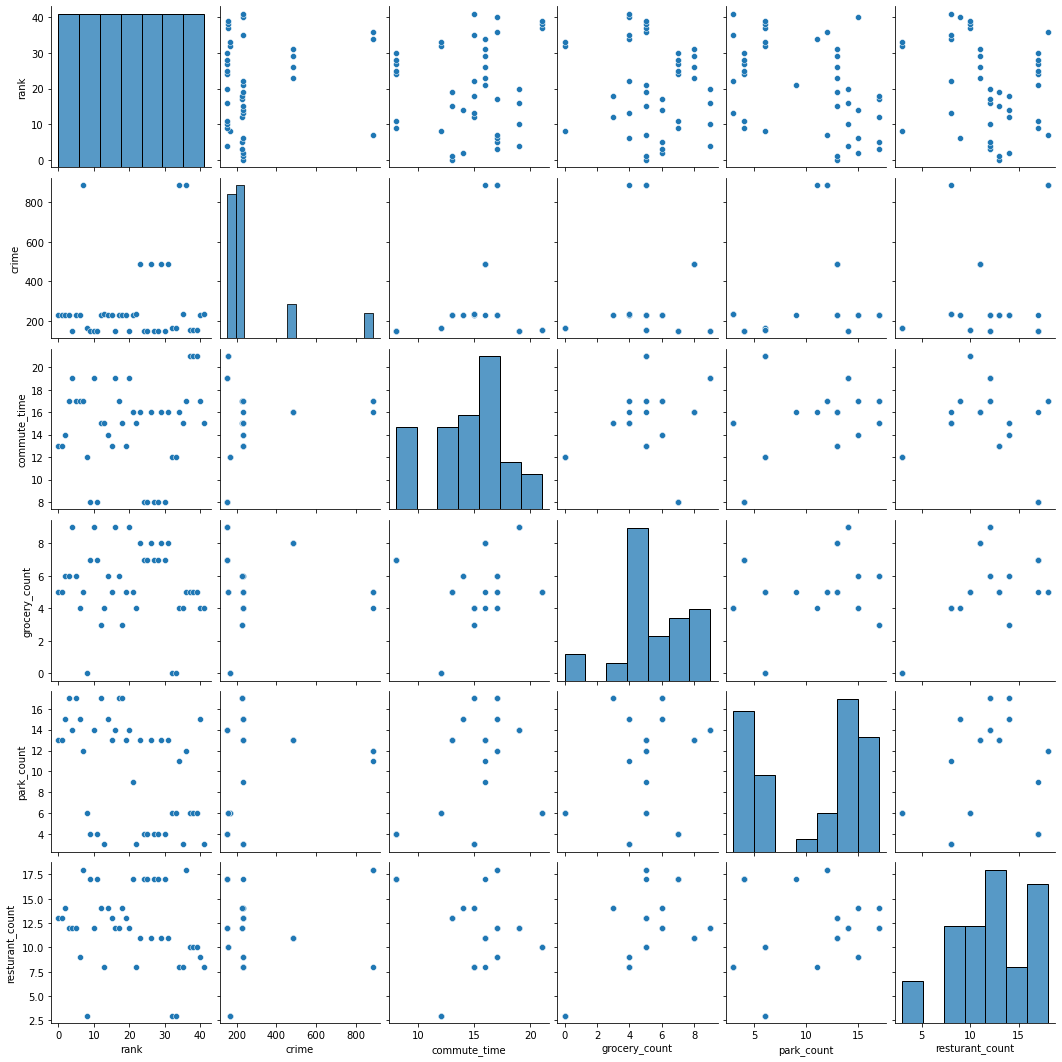

In [38]:
column_set = ['rank','crime','commute_time','grocery_count','park_count','resturant_count']

grd = sns.pairplot(data=df_sorted[column_set])

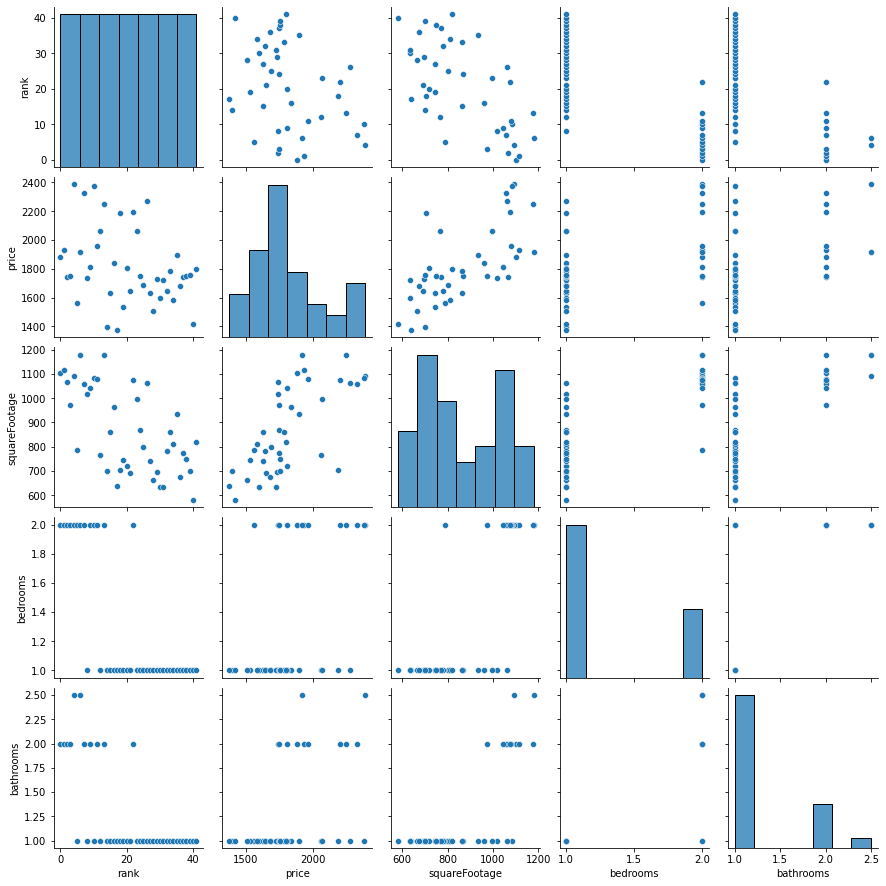

In [39]:
column_set2 = ['rank','price','squareFootage','bedrooms','bathrooms']
grd = sns.pairplot(data=df_sorted[column_set2])